In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

pd.set_option('display.max_rows', None)
sns.set_context('talk')

In [68]:
# ZORA data
mrchem = pd.read_csv('datafiles/MRChem_MW7.csv')
orca = pd.read_csv('datafiles/ZORA_ORCA.csv')
df = mrchem.merge(orca, how='outer', on=['Atom', 'LightSpeed'], suffixes=['_mw7', '_gto']).sort_values(by=['BasisSet', 'Atom', 'LightSpeed']).reset_index(drop=True)
df.drop('Input', axis=1, inplace=True)
df['Error'] = abs(df.Energy_gto - df.Energy_mw7)

# NR reference data
ref_mrchem = pd.read_csv('datafiles/NR_MRChem.csv')
ref_orca = pd.read_csv('datafiles/NR_ORCA.csv')
ref = ref_mrchem.merge(ref_orca, how='outer', on='Atom', suffixes=['_mw7', '_gto']).sort_values(by=['Atom', 'BasisSet']).reset_index(drop=True)
ref['Error'] = ref.Energy_gto - ref.Energy_mw7

In [69]:
# Add familities to df
mapping = {
    'ano-rcc-dzp': 'ANO-RCC', 'ano-rcc-tzp': 'ANO-RCC', 'ano-rcc-qzp': 'ANO-RCC',
    'cc-pcvdz': 'CCc', 'cc-pcvtz': 'CCc', 'cc-pcvqz': 'CCc', 'cc-pcv5z': 'CCc',
    'cc-pvdz': 'CC', 'cc-pvtz': 'CC', 'cc-pvqz': 'CC', 'cc-pv5z': 'CC',
    'def2-svp': 'Def2', 'def2-tzvp': 'Def2', 'def2-qzvpp': 'Def2',
    'pc-1': 'PC', 'pc-2': 'PC', 'pc-3': 'PC', 'pc-4': 'PC',
    'zora-def2-svp': 'Zora-Def2', 'zora-def2-tzvp': 'Zora-Def2', 'zora-def2-qzvpp': 'Zora-Def2'}
df['Family'] = df.BasisSet.map(lambda b: mapping[b])

In [70]:
xticks = [34.25899725, 68.5179945, 137.035989, 274.071978, 548.143956, 1096.287912, 2192.575824, 4385.151648]
xticklabels = ['c/4', 'c/2', 'c', '2c', '4c', '8c', '16c', '32c']

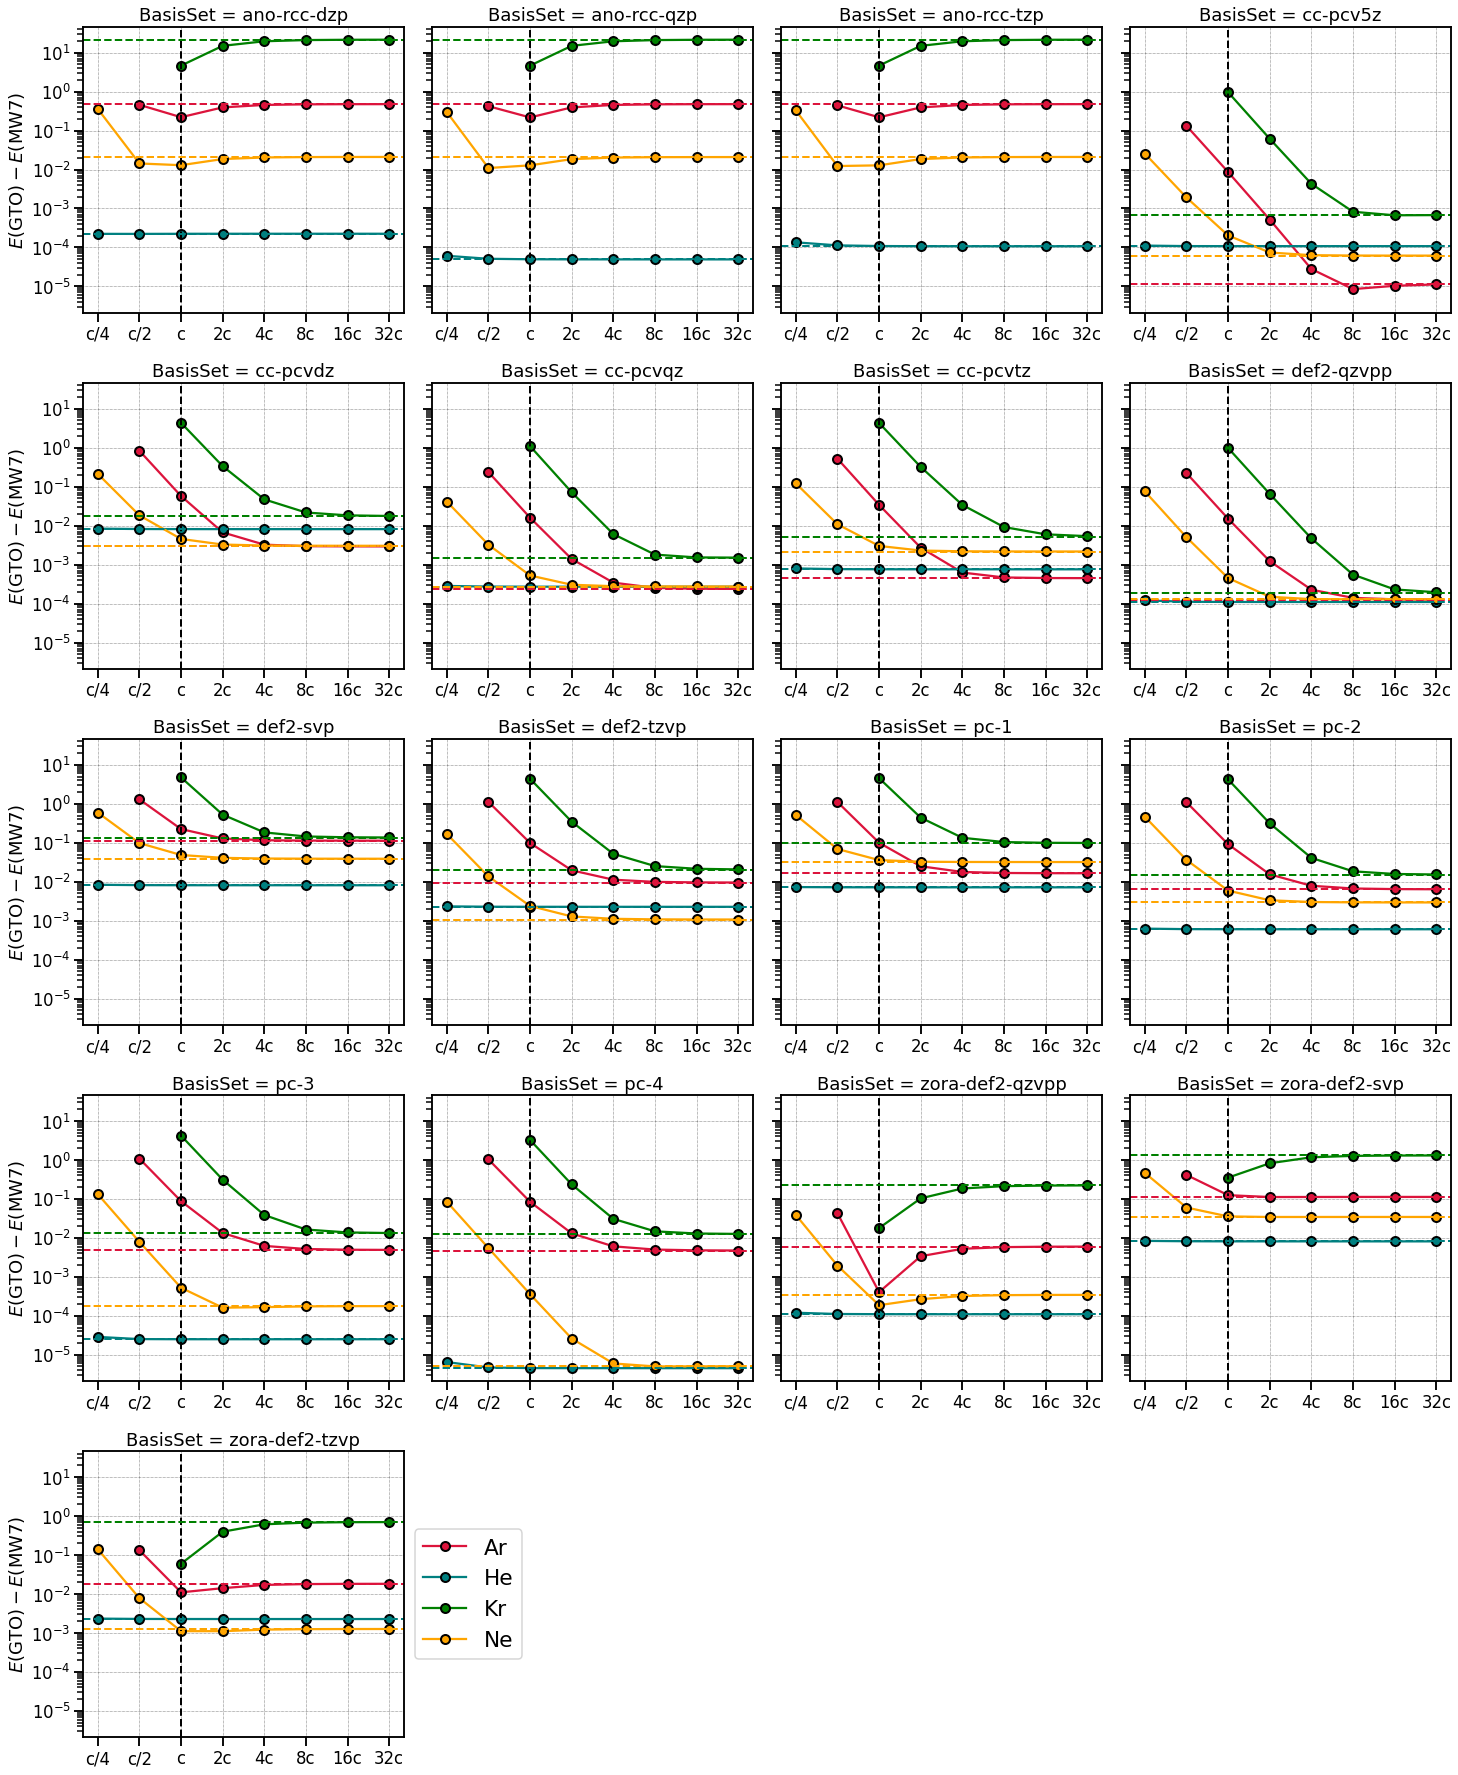

In [71]:
palette = ['crimson', 'teal', 'green', 'orange']
atoms = list(df.Atom.unique())

grid = sns.relplot(data=df, 
                   palette=palette, 
                   x='LightSpeed', 
                   y='Error', 
                   hue='Atom', 
                   col='BasisSet', 
                   mec='black', 
                   mew=2, 
                   col_wrap=4, 
                   facet_kws={'sharey': True,
                              'sharex': False,
                              'despine': False}, 
                   kind='line', 
                   marker='o', 
                   legend=False)

counter = 0
lines = []
for basis, ax in grid.axes_dict.items():
    if counter == 0:
        for p, a in zip(palette, atoms):
            lines.append(Line2D([], [], label=a, color=p, marker='o', mec='black', mew=2))
            
    counter += 1
    ax.set_yscale('log')
    ax.set_xscale('log', base=2)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.grid(ls=':', lw=0.5, color='black')
    ax.set_ylabel(r'$E(\mathrm{GTO}) - E(\mathrm{MW7})$')
    ax.set_xlabel(None)
    ax.axvline(xticks[2], ls='--', lw=2, color='black')
    
    for p, a in zip(palette, atoms):
        e = ref.loc[(ref.BasisSet == basis) & (ref.Atom == a)].Error.values[0]
        ax.axhline(e, ls='--', color=p, lw=2)
    
plt.legend(lines, atoms, ncol=1, bbox_to_anchor=(1.0, 0.5), loc='center left', fontsize='large')
plt.savefig('Figure1.png', facecolor='white')

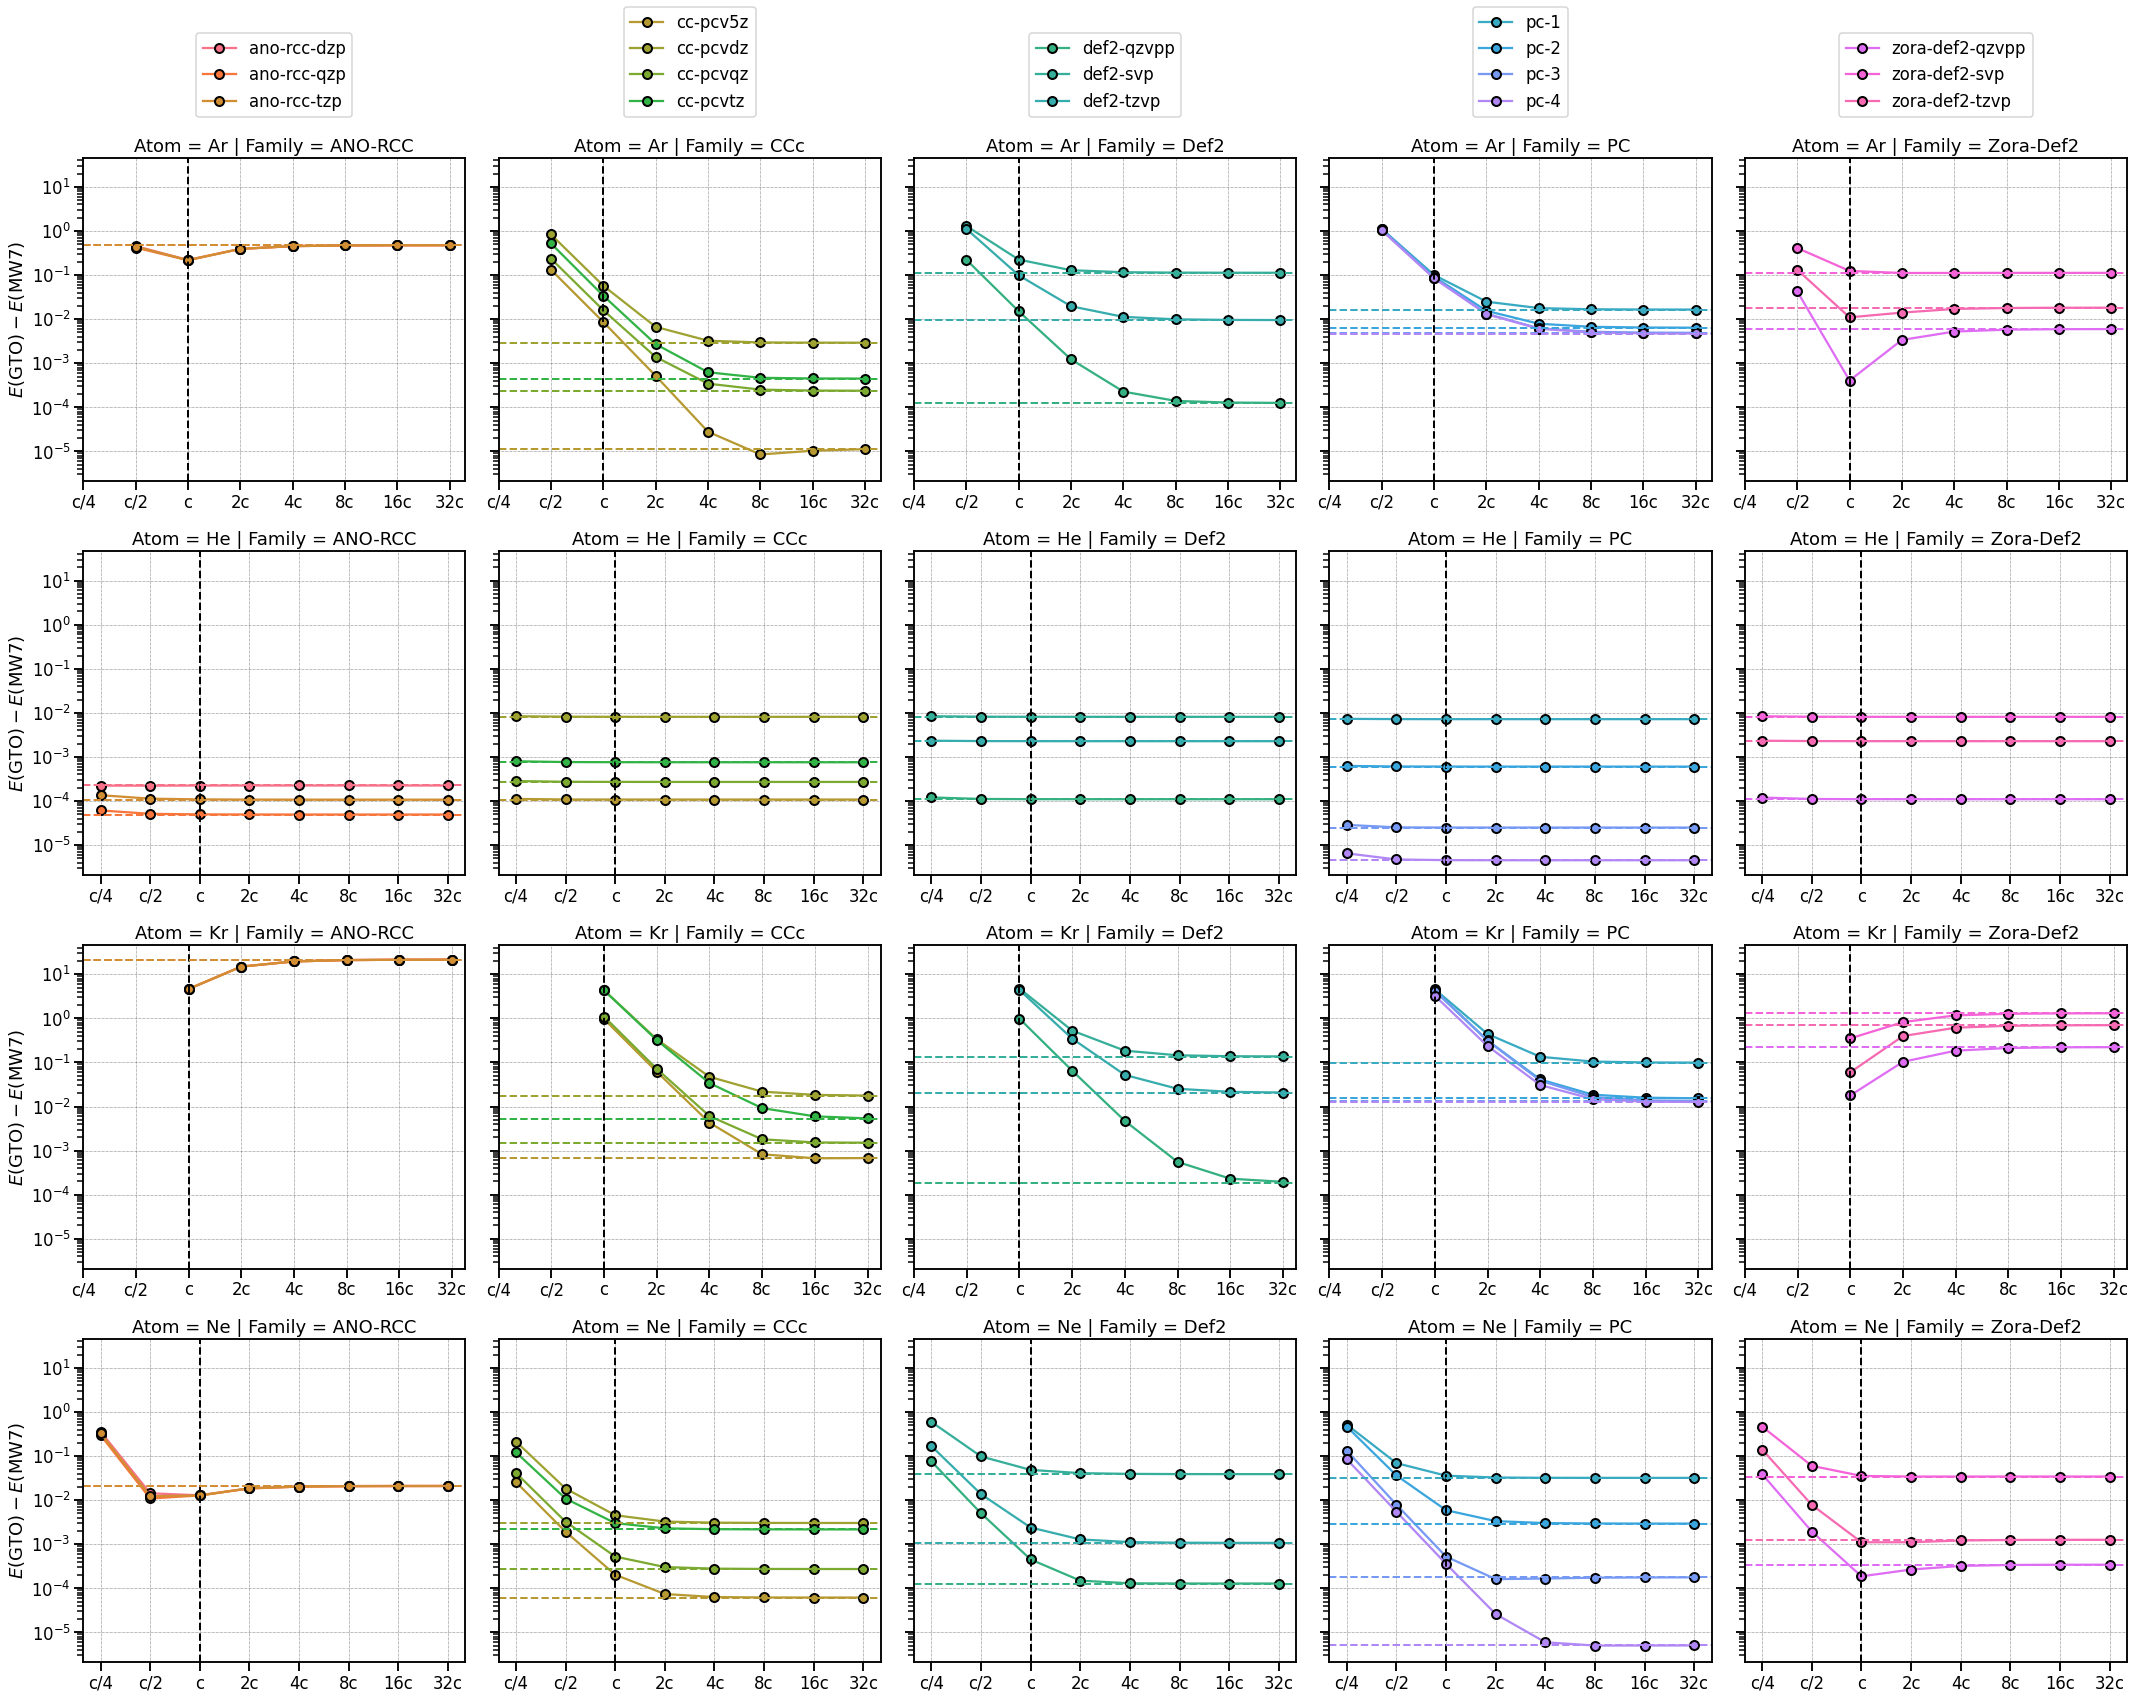

In [72]:
grid = sns.relplot(data=df, 
                   x='LightSpeed', 
                   y='Error', 
                   hue='BasisSet', 
                   col='Family',
                   row='Atom',
                   mec='black', 
                   mew=2, 
                   col_wrap=None, 
                   facet_kws={'sharey': True, 
                              'sharex': False,
                              'despine': False}, 
                   kind='line', 
                   marker='o', 
                   legend=False,
                   height=6)

counter = 0
for (atom, fam), ax in grid.axes_dict.items():
    lines = ax.get_lines()
    basis_sets = df.loc[df.Family == fam].BasisSet.unique()
    if counter < 5:
        ax.legend(lines, basis_sets, bbox_to_anchor=(0.5, 1.1), loc='lower center')
    counter += 1
    
    ax.set_yscale('log')
    ax.set_xscale('log', base=2)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.grid(ls=':', lw=0.5, color='black')
    ax.set_ylabel(r'$E(\mathrm{GTO}) - E(\mathrm{MW7})$')
    ax.set_xlabel(None)
    ax.axvline(xticks[2], ls='--', lw=2, color='black')
    
    for basis, line in zip(basis_sets, lines):
        e = ref.loc[(ref.BasisSet == basis) & (ref.Atom == atom)].Error.values[0]
        ax.axhline(e, ls='--', lw=2, color=line._color)
    
plt.tight_layout()
plt.savefig('Figure2.png', facecolor='white')